In [1]:
import numpy as np
from numpy.random import randint
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import EngFormatter, StrMethodFormatter

In [2]:
plt.rcParams['text.usetex'] = True
sns.set_style("whitegrid")
sns.despine()
plt.style.use(['science', 'notebook'])

<Figure size 432x288 with 0 Axes>

In [3]:
# Auxiliary functions

def L1(x):
    p, k = x
    return 1/(2*p*k) * (-2*p+1+3*p*k+ m.sqrt((2*p-1-p*k)**2 + 4*p*k))

def L2(x):
    p, k = x
    return 4*p -4*k*p + L1(x)

def L3(x):
    p, k = x
    return 2*p*k/L1(x) * (2 + 2*L1(x)/(2*p) -2*k)


def u(f):
    if f >= 0:
        return f
    else:
        return 0

In [4]:
# function for the controller

def nOfSelections(k, feedback):

    const = int(feedback)


    if np.random.random() <= feedback - const:

        return k + const + 1

    else:
        
        return k + const


In [5]:
# Classes to simulate the Tangle

class Transaction:

    def __init__(self, ID):
        self.ID = ID
        self.children = []
        self.age = 0

    def attach(self, children):

        for child in set(children):
            self.children.append(child)

    def setAge(self, t):

        self.age += t



class Tangle:

    def __init__(self, PoW):

        self.nOfTransactions = 1
        self.h = PoW
        genesis = Transaction(0)
        self.transactions = [genesis]
        self.transactionsPending = []
        self.tips = [genesis]
        



    def newTransaction(self, k, q = 1):

        
        tx = Transaction(self.nOfTransactions + 1)
        
        if np.random.random() > q:

                tx.attach(self.randomSelection(0))

        else:

                tx.attach(self.randomSelection(k))
        
        self.addTransaction(tx)






    def addTransaction(self, transaction):

        self.transactionsPending.append(transaction)
        self.transactions.append(transaction)
        self.nOfTransactions += 1






    def checkPoW(self):


        for tx in self.transactionsPending:
            
            if tx.age >= self.h:

                self.transactionsPending.remove(tx)
                self.tips.append(tx)

                for child in tx.children:
                    
                    
                    if child in self.tips:
                        self.tips.remove(child)

                        
        return len(self.tips)
    



    def increaseAge(self, t):

        for transaction in self.transactions:

            transaction.setAge(t)



    
    def randomSelection(self, k):
        
        length = len(self.tips)
        selections = [self.tips[randint(length)] for i in range(k)]

        return selections



In [ ]:
# Equilibrium of the Tangle without Control and under Tips Inflation Attack

lam = 100
h = 1
k = 2
P = np.arange(1,0.501,-0.01)

solution = []
for p in P:
    
    
    
    solution.append(p * k * lam * h / (p * k - 1) )

plt.plot(P, solution)


plt.xlabel(r"$p$")
plt.ylabel(r"$\tilde{l}$")
plt.title(r"Equilibrium of the Tangle for $k = 2$")

In [ ]:
# Simulations for Attack scenario with no control

step = 0.01
lam = 100
h = 1
m = 1
k = 2
q = 0.6
MC = 100


time = np.arange(0, 60, step)

for q in np.arange(1, 0.3, -0.1):

    L = []
    for mc in range(MC):
        l = np.array([])
        tangle = Tangle(h)
        for t in time:
            if np.random.random() < step*lam:
                tangle.newTransaction(k,q)

            l = np.append(l, tangle.checkPoW())
            tangle.increaseAge(step)
        L.append(l)
    M = np.mean(L, axis = 0)
        

    q_form = "{:.1f}".format(q)
    plt.plot(time, M, label = r"$q =$ "+ str(q_form))


plt.legend(loc="upper left")
plt.xlabel("Time [s]")
plt.ylabel(r"$L(t)$")
plt.title("Leaves with no control")

In [ ]:
# Simulations of attack scenario with control


_, ax2 = plt.subplots(ncols=1)
_, ax1 = plt.subplots(ncols=1)

step = 0.01
lam = 30
h = 1
m = 2
k = 2
q = 0.4
MC = 100




time = np.arange(0, 60, step)


for m in np.arange(1, 5, 1):

    L = []
    F = []
    for mc in range(MC):
        l = np.array([])
        f = np.array([])
        tangle = Tangle(h)
        for t in time:

            if np.random.random() < step*lam:

                feedback = u(m/(lam * h)*(len(tangle.tips) - 2 * lam * h))
                tangle.newTransaction(nOfSelections(k, feedback),q)
                f = np.append(f, k + feedback)

            l = np.append(l, tangle.checkPoW())
            tangle.increaseAge(step)
        L.append(l)
        F.append(f)
    M = np.mean(L, axis = 0)
        

    m_form = "{:.1f}".format(m)
    ax2.plot(time, M, label = r"$m =$ "+ str(m_form))
    ax1.plot(time, F, label = r"$m =$ "+ str(m_form))

ax2.legend(loc="lower right")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel(r"$L(t)$")
ax2.set_title("Leaves with Feedback")

ax1.legend(loc="lower right")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel(r"$k(t)$")
ax1.set_title("Number of Selections")

Text(0.5, 1.0, 'Number of Selections')

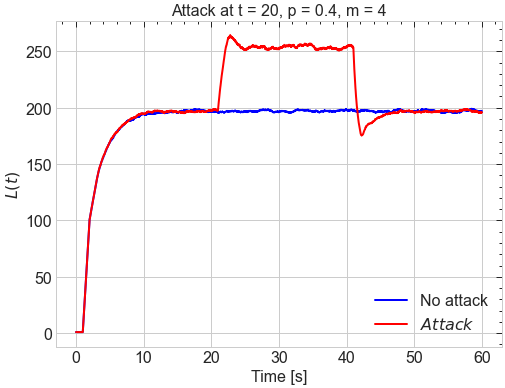

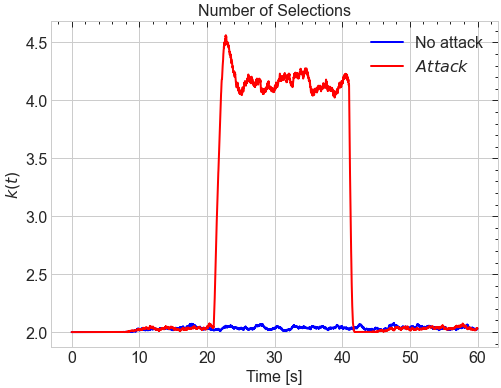

In [8]:
# Simulations of Attack scenario with control in a time window

_, ax2 = plt.subplots(ncols=1)
_, ax1 = plt.subplots(ncols=1)

step = 0.01
lam = 100
h = 1
m = 4
k = 2
q = 0.4
MC = 50
attackTime = 20
attackStopTime = 40




time = np.arange(0, 60, step)


L = []
F = []
for mc in range(MC):
    l = np.array([])
    f = np.array([])
    tangle = Tangle(h)
    for t in time:

        if np.random.random() < step*lam:

            feedback = u(m/(lam * h)*(len(tangle.tips) - 2 * lam * h))
            tangle.newTransaction(nOfSelections(k, feedback),1)
            f = np.append(f, k + feedback)

        l = np.append(l, tangle.checkPoW())
        tangle.increaseAge(step)
    L.append(l)
    F.append(f)
M = np.mean(L, axis = 0)
F = np.mean(F, axis = 0)

ax2.plot(time, M, "b", label = "No attack")
ax1.plot(time, F, "b", label = "No attack")

L = []
F = []
for mc in range(MC):
    l = np.array([])
    f = np.array([])
    tangle = Tangle(h)
    for t in time:

        if np.random.random() < step*lam:

            feedback = u(m/(lam * h)*(len(tangle.tips) - 2 * lam * h))
            if t >= attackTime and t <= attackStopTime:
                tangle.newTransaction(nOfSelections(k, feedback),q)
            else:
                tangle.newTransaction(nOfSelections(k, feedback),1)
            f = np.append(f, k + feedback)

        l = np.append(l, tangle.checkPoW())
        tangle.increaseAge(step)
    L.append(l)
    F.append(f)
M = np.mean(L, axis = 0)
F = np.mean(F, axis = 0)
        
ax2.plot(time, M, "r", label = "Attack")
ax1.plot(time, F, "r", label = "Attack")

ax2.legend(loc="lower right")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel(r"$L(t)$")
ax2.set_title("Attack at t = 20, p = 0.4, m = 4")

ax1.legend(loc="upper right")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel(r"$k(t)$")
ax1.set_title("Number of Selections")

In [ ]:
# Computations of the equilibrium with control

_, ax = plt.subplots(ncols=1)

beta = 100
h = 1

P = np.arange(1,0.3,-0.1)
K = np.arange(1,10,0.25)
t = 1
for p in P:
    solution = []
    for k in K: 
        x = (p,k)
        solution.append(L1(x) * beta * h)
    t_form = "{:.1f}".format(t)
    ax.plot(K, solution, label = r"$p = $ " + str(t_form))
    t -= 0.1
ax.legend(loc="upper right")
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$\tilde{l}$")
ax.set_title(r"Equilibrium vs Gain, $\beta = 100, h = 1$")


